In [ ]:
from collections import defaultdict
import unicodedata as ud
import pandas as pd
import numpy as np
import math
import ast
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**1. Dữ liệu**


In [ ]:
sentences = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/sentences.txt', encoding='utf-8').readlines()
tokenize_sentences = [sentence.split(' ') for sentence in sentences]

In [ ]:
print('Số lượng câu đã thu thập:', len(sentences))
sentences[0:2]

Số lượng câu đã thu thập: 60


['Trong hơn 1.500 bảng quảng cáo ngoài trời tại TP.HCM có 49% điểm không phép , chủ yếu ở các vòng xoay , chân cầu vượt , tuyến đường lớn của các quận trung tâm .\n',
 'UBND tỉnh Bạc Liêu trao giấy chứng nhận đầu tư 13 dự án với tổng vốn hơn 16.700 tỷ đồng vào các lĩnh vực nông nghiệp , thương mại , hạ tầng .\n']

In [ ]:
max_str = max(tokenize_sentences, key=len)
print('Câu có số từ nhiều nhât:', len(max_str))
' '.join(max_str)

Câu có số từ nhiều nhât: 43


'Ở Việt Nam , cuộc sống đã gần như bình thường : sự nhộn nhịp trở lại khắp các con phố ; cửa hàng , quán cà phê chật cứng ; khách du lịch quốc tế cũng đang đổ tới Việt Nam .\n'

In [ ]:
min_str = min(tokenize_sentences, key=len)
print('Câu có số từ ít nhât:', len(min_str))
' '.join(min_str)

Câu có số từ ít nhât: 6


'Con mèo trèo cây cau .\n'

#**2. Tách từ**


## **Thuật toán Longest Matching**

In [ ]:
def syllablize(sentence):
    word = '\w+'
    non_word = '[^\w\s]'
    digits = '\d+([\.,_]\d+)+'
    
    patterns = []
    patterns.extend([word, non_word, digits])
    patterns = f"({'|'.join(patterns)})"
    
    sentence = ud.normalize('NFC', sentence)
    tokens = re.findall(patterns, sentence, re.UNICODE)
    return [token[0] for token in tokens]

In [ ]:
def load_n_grams(path):
    with open(path, encoding='utf8') as f:
        words = f.read()
        words = ast.literal_eval(words)
    return words

In [ ]:
def longest_matching(sentence, bi_grams, tri_grams):
    syllables = syllablize(sentence)
    syl_len = len(syllables)
    
    curr_id = 0
    word_list = []
    done = False
    
    while (curr_id < syl_len) and (not done):
        curr_word = syllables[curr_id]
        if curr_id >= syl_len - 1:
            word_list.append(curr_word)
            done = True
        else:
            next_word = syllables[curr_id + 1]
            pair_word = ' '.join([curr_word.lower(), next_word.lower()])
            if curr_id >= (syl_len - 2):
                if pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
            else:
                next_next_word = syllables[curr_id + 2]
                triple_word = ' '.join([pair_word, next_next_word.lower()])
                if triple_word in tri_grams:
                    word_list.append('_'.join([curr_word, next_word, next_next_word]))
                    curr_id += 3
                elif pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
    return word_list

In [ ]:
bi_grams = load_n_grams('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/resources/bi_grams.txt')
tri_grams = load_n_grams('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/resources/tri_grams.txt')
# TEST
longest_matching('Du học sinh Việt đối mặt loạt chiêu trò lừa đảo tại Mỹ, tôi là học sinh, tôi ăn cơm', bi_grams, tri_grams)

['Du_học_sinh',
 'Việt',
 'đối_mặt',
 'loạt',
 'chiêu',
 'trò',
 'lừa_đảo',
 'tại',
 'Mỹ',
 ',',
 'tôi',
 'là',
 'học_sinh',
 ',',
 'tôi',
 'ăn',
 'cơm']

In [ ]:
len(bi_grams)

22705

In [ ]:
len(tri_grams)

1907

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/longest_matching_tokens.txt', 'w', encoding='utf-8') as f:
    longest_matching_sentences = []
    for sentence in sentences:
        word_list = longest_matching(sentence, bi_grams, tri_grams)
        longest_matching_sentences.append(' '.join(word_list))
        for word in word_list: f.write(word + '\n')
        if sentence != sentences[-1]: f.write('\n')
    f.write('\n')
longest_matching_sentences[0:3]

['Trong hơn 1 . 500 bảng quảng_cáo ngoài_trời tại TP . HCM có 49 % điểm không phép , chủ_yếu ở các vòng xoay , chân cầu_vượt , tuyến đường lớn của các quận trung_tâm .',
 'UBND tỉnh Bạc Liêu trao giấy chứng_nhận đầu_tư 13 dự_án với tổng vốn hơn 16 . 700 tỷ đồng vào các lĩnh_vực nông_nghiệp , thương_mại , hạ tầng .',
 'Là nhà nghiên_cứu giáo_dục và truyền_thông khoa_học , Hoàng - đồng_nghiệp của tôi - rất bối_rối trước bài_học của cậu con_trai lớp 7 .']

In [ ]:
count_longest_matching_compounds = 0
for sentence in longest_matching_sentences:
    for word in sentence.split():
        if '_' in word: count_longest_matching_compounds += 1
print('Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching:', count_longest_matching_compounds)

Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching: 184


## **Thư viện VNCoreNLP**

In [ ]:
!pip install py_vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 23.2 MB/s 
  Created wheel for py-vncorenlp: filename=py_vncorenlp-0.1.3-py3-none-any.whl size=4307 sha256=8d997efc206990eedf6916b7b589a7da760f486cbff171688e5fa221a8601027
  Stored in directory: /root/.cache/pip/wheels/d7/73/13/6b1f2c14831151fc1417f3dc1fa6b241e27ad13f8c83691753
Successfully built py-vncorenlp


In [ ]:
import py_vncorenlp
py_vncorenlp.download_model(save_dir='./')
model = py_vncorenlp.VnCoreNLP(annotators=["wseg", "pos", "ner", "parse"], save_dir='./')

In [ ]:
# TEST
text = "Ông Nguyễn Khắc Chúc đang làm việc tại Đại học Quốc gia Hà Nội."
output = model.word_segment(text)
print(output)

['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .']


In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/vncore_tokens.txt', 'w', encoding='utf-8') as f:
  vncore_sentences = []
  for sentence in sentences:
    output = model.word_segment(sentence)
    for sentence in output:
      vncore_sentences.append(sentence)
      for word in sentence.split():
        f.write(word+'\n')
      f.write('\n')
  print(vncore_sentences[0:5])

['Trong hơn 1.500 bảng quảng_cáo ngoài_trời tại TP. HCM có 49% điểm không phép , chủ_yếu ở các vòng xoay , chân cầu_vượt , tuyến đường lớn của các quận trung_tâm .', 'UBND tỉnh Bạc_Liêu trao giấy chứng_nhận đầu_tư 13 dự_án với tổng vốn hơn 16.700 tỷ đồng vào các lĩnh_vực nông_nghiệp , thương_mại , hạ_tầng .', 'Là nhà_nghiên_cứu giáo_dục và truyền_thông khoa_học , Hoàng - đồng_nghiệp của tôi - rất bối_rối trước bài_học của cậu con trai lớp 7 .', 'Ở Việt_Nam , cuộc_sống đã gần như bình_thường : sự nhộn_nhịp trở_lại khắp các con phố ; cửa_hàng , quán cà_phê chật_cứng ; khách du_lịch quốc_tế cũng đang đổ tới Việt_Nam .', 'Chính_quyền thành_phố Bắc_Kinh cấm chặn cổng nhà dân và lối ra vào toà chung_cư nhằm " tối_ưu_hoá " biện_pháp kiểm_soát chống Covid-19 .']


In [ ]:
count_vncore_compounds = 0
for sentence in vncore_sentences:
    for word in sentence.split():
        if '_' in word: count_vncore_compounds += 1
print('Số lượng từ ghép khi tách từ bằng thư viện VnCoreNLP:', count_vncore_compounds)

Số lượng từ ghép khi tách từ bằng thư viện VnCoreNLP: 206


  ## **Thủ công**

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/manual_tokens.txt', 'r', encoding='utf-8') as f:
    manual_tokenize_sentences = []
    sentence = ''
    for word in f:
        if word == '\n': 
            manual_tokenize_sentences.append(sentence.strip())
            sentence = ''
        else: sentence += word.replace('\n', ' ')
manual_tokenize_sentences[0:5]

['Trong hơn 1.500 bảng_quảng_cáo ngoài_trời tại TP.HCM có 49% điểm không phép , chủ_yếu ở các vòng_xoay , chân cầu_vượt , tuyến_đường lớn của các quận trung_tâm .',
 'UBND tỉnh Bạc_Liêu trao giấy chứng_nhận đầu_tư 13 dự_án với tổng vốn hơn 16.700 tỷ đồng vào các lĩnh_vực nông_nghiệp , thương_mại , hạ_tầng .',
 'Là nhà_nghiên_cứu giáo_dục và truyền_thông khoa_học , Hoàng - đồng_nghiệp của tôi - rất bối_rối trước bài_học của cậu con_trai lớp 7 .',
 'Ở Việt_Nam , cuộc_sống đã gần như bình_thường : sự nhộn_nhịp trở_lại khắp các con_phố ; cửa_hàng , quán cà_phê chật_cứng ; khách du_lịch quốc_tế cũng đang đổ tới Việt_Nam .',
 'Chính_quyền thành_phố Bắc_Kinh cấm chặn cổng nhà dân và lối ra vào toà chung_cư nhằm " tối_ưu_hoá " biện_pháp kiểm_soát chống Covid-19 .']

In [ ]:
count_manual_tokenize_compounds = 0
for sentence in manual_tokenize_sentences:
    for word in sentence.split():
        if '_' in word: count_manual_tokenize_compounds += 1
print('Số lượng từ ghép khi tách từ thủ công:', count_manual_tokenize_compounds)

Số lượng từ ghép khi tách từ thủ công: 218


## **Đánh giá kết quả tách từ**

In [ ]:
def count_correct_words(pred, source, n_grams=3):
    pred_words = pred.split()
    source_words = source.split()
    
    total_true, tp = 0, 0
    total_errors, fp = 0, 0
    
    idx = 0
    while idx < len(pred_words):
        if pred_words[idx] not in source_words[idx:(idx + n_grams)]: 
            if '_' in pred_words[idx]: fp += 1
            del pred_words[idx]
            total_errors += 1
        else: idx += 1
    
    idx = 0
    while idx < len(source_words):
        if source_words[idx] not in pred_words[idx:(idx + n_grams)]: 
            del source_words[idx]
        else: idx += 1
    
    if len(pred_words) < len(source_words): words = pred_words
    else: words = source_words
    
    for idx in range (len(words)):
        if pred_words[idx] == source_words[idx]:
            if '_' in pred_words[idx]: tp += 1 
            total_true += 1
                    
    return total_true, total_errors, tp, fp

In [ ]:
def tokenize_evaluation(pred, source, n_grams=3):
    total_true = 0
    total_errors = 0
    total_words = 0
    
    pred_tp = 0
    pred_fp = 0
    
    for pred_sentence, source_sentence in zip(pred, source):
        total_words += len(source_sentence.split())
        if pred_sentence != source_sentence:
            true, error, tp, fp = count_correct_words(pred_sentence, source_sentence, n_grams)
            total_true += true 
            total_errors += error
            pred_tp += tp
            pred_fp += fp
        else:
            for word in source_sentence.split():
                if '_' in word: pred_tp += 1
                total_true += 1
    return {
        'Accuracy': total_true / total_words, 
        'Precision': pred_tp / (pred_tp + pred_fp),
        'Recall': pred_tp / count_manual_tokenize_compounds,
        'True Positive': pred_tp, 
        'False Positive': pred_fp,
        'Total True': total_true, 
        'Total Errors': total_errors
    }

In [ ]:
longest_matching_evaluation = tokenize_evaluation(longest_matching_sentences, manual_tokenize_sentences)
vncore_evaluation = tokenize_evaluation(vncore_sentences, manual_tokenize_sentences)
pd.DataFrame(
    [longest_matching_evaluation, vncore_evaluation], 
    index = ['Longest Matching', 'VnCoreNLP']
).astype(object).T

,Longest Matching,VnCoreNLP
Accuracy,0.885989,0.962912
Precision,0.929348,0.980583
Recall,0.784404,0.926606
True Positive,171,202
False Positive,13,4
Total True,645,701
Total Errors,143,42


#**3. Gán nhãn**


In [ ]:
longest_matching_tokens = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/longest_matching_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(longest_matching_tokens))
longest_matching_tokens[0:5]

Số lượng từ: 854


['Trong\n', 'hơn\n', '1\n', '.\n', '500\n']

In [ ]:
vncore_tokens = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/vncore_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(vncore_tokens))
vncore_tokens[0:5]

Số lượng từ: 809


['Trong\n', 'hơn\n', '1.500\n', 'bảng\n', 'quảng_cáo\n']

In [ ]:
manual_tokens = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/results/manual_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(manual_tokens))
manual_tokens[0:5]

Số lượng từ: 793


['Trong\n', 'hơn\n', '1.500\n', 'bảng_quảng_cáo\n', 'ngoài_trời\n']

In [ ]:
# TEST
sentences = model.annotate_text("Ông Nguyễn Khắc Chúc đang làm việc tại Đại học Quốc gia Hà Nội.")
# if sentences=={}: print("")
sentences

{0: [{'index': 1,
   'wordForm': 'Ông',
   'posTag': 'Nc',
   'nerLabel': 'O',
   'head': 4,
   'depLabel': 'sub'},
  {'index': 2,
   'wordForm': 'Nguyễn_Khắc_Chúc',
   'posTag': 'Np',
   'nerLabel': 'B-PER',
   'head': 1,
   'depLabel': 'nmod'},
  {'index': 3,
   'wordForm': 'đang',
   'posTag': 'R',
   'nerLabel': 'O',
   'head': 4,
   'depLabel': 'adv'},
  {'index': 4,
   'wordForm': 'làm_việc',
   'posTag': 'V',
   'nerLabel': 'O',
   'head': 0,
   'depLabel': 'root'},
  {'index': 5,
   'wordForm': 'tại',
   'posTag': 'E',
   'nerLabel': 'O',
   'head': 4,
   'depLabel': 'loc'},
  {'index': 6,
   'wordForm': 'Đại_học',
   'posTag': 'N',
   'nerLabel': 'B-ORG',
   'head': 5,
   'depLabel': 'pob'},
  {'index': 7,
   'wordForm': 'Quốc_gia',
   'posTag': 'N',
   'nerLabel': 'I-ORG',
   'head': 6,
   'depLabel': 'nmod'},
  {'index': 8,
   'wordForm': 'Hà_Nội',
   'posTag': 'Np',
   'nerLabel': 'I-ORG',
   'head': 6,
   'depLabel': 'nmod'},
  {'index': 9,
   'wordForm': '.',
   'posTag':

In [ ]:
# TEST
sentence = sentences[0]
for word in sentence:
  print(word['wordForm'], word['posTag'])

Ông Nc
Nguyễn_Khắc_Chúc Np
đang R
làm_việc V
tại E
Đại_học N
Quốc_gia N
Hà_Nội Np
. CH


In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/gold_temp.txt', 'w', encoding='utf-8') as f:
    for word in vncore_tokens:
        word = word.replace('\n', '')
        
        if '_' not in word: tag = model.annotate_text(word)
        else: tag = model.annotate_text(word.replace('_', ' '))
        
        if tag == {}: f.write('\n')
        
        else: f.write(word+"\t"+tag[0][0]['posTag']+"\n")
    f.write('\n')

  - **Chia Dataset**

In [ ]:
gold_corpus = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/gold.txt', encoding='utf-8').readlines()
new_line_idx = [i for i, item in enumerate(vncore_tokens) if item == '\n']

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/train_gold.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[:new_line_idx[45]]: f.write(line)

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/test_gold.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[new_line_idx[45]:]: f.write(line)

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/train_words.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[:new_line_idx[45]]: f.write(re.sub('\t.*', '', line))     
    
with open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/test_words.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[new_line_idx[45]:]: f.write(re.sub('\t.*', '', line))

#**4. Xử lý dữ liệu**

In [ ]:
def preprocess(vocabs_dict, path):
    data = []
    file = open(path, encoding='utf-8').readlines()
    
    for index, word in enumerate(file):
        if not word.split():
            word = '--n--'
            data.append(word)
            continue
        elif word.strip() not in vocabs_dict:
            word = '--unk--'
            data.append(word)
            continue
        data.append(word.strip())
    return data

In [ ]:
def plot_tag_counts(gold):
    tags = [word_tag.split()[1] for word_tag in gold if word_tag.split()]
    tag_counts = pd.DataFrame(tags)[0].value_counts()
    tag_counts.plot.bar(rot=0, width=0.7, legend=False, figsize=(15, 5))
    return pd.DataFrame(tag_counts).T.assign(Total=tag_counts.sum()) 


  ## **Từ vựng**

In [ ]:
vocabs = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/resources/vocabs.txt', encoding='utf-8').read().split('\n')
vocabs_dict = {}
index = 0

for word in sorted(vocabs): 
    if word not in vocabs_dict: 
        vocabs_dict[word] = index  
        index += 1


In [ ]:
print('Số lượng từ vựng:', len(vocabs_dict.keys()))
count = 0

for key, value in vocabs_dict.items():
    print(f'{key}: {value}')
    count += 1
    if count > 20: break

Số lượng từ vựng: 54854
!: 0
": 1
#: 2
$: 3
%: 4
&: 5
': 6
'': 7
'40s: 8
'60s: 9
'70s: 10
'80s: 11
'86: 12
'90s: 13
'N: 14
'S: 15
'd: 16
'em: 17
'll: 18
'm: 19
'n': 20


##**Chia Dataset**

- **Train data**

In [ ]:
train_gold = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/train_gold.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập train_gold:', len(train_gold))
train_gold[0:5]

Số lượng từ trong tập train_gold: 661


['Trong\tE\n',
 'hơn\tA\n',
 '1.500\tM\n',
 'bảng_quảng_cáo\tN\n',
 'ngoài_trời\tX\n']

In [ ]:
train_words = preprocess(vocabs_dict, '/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/train_words.txt')
print('Số lượng từ trong tập train_words:', len(train_words))
train_words[0:5]

Số lượng từ trong tập train_words: 661


['Trong', 'hơn', '1.500', '--unk--', 'ngoài_trời']

Các từ không nằm trong vocabs: bảng_quảng_cáo, TP.HCM, 49%, vòng_xoay, tuyến_đường, Bạc_Liêu, hạ_tầng, nhà_nghiên_cứu, Hoàng, Việt_Nam, con_phố, Việt_Nam, Bắc_Kinh, tối_ưu_hoá, Bắc_Kinh, Messi, Con_trai, Arab_Saudi, Việt_Nam, Phương_Tây, châu_Á, Bỉ, Ronaldo, Instagram, Neymar, Serbia, World_Cup, Costa_Rica, World_Cup, Việt_Nam, bài_thi, Tân_Sơn_Nhất, khảo_thí, Hầu_hết, TP.HCM, Tết_Nguyên_đán, Hơn, Việt, chiêu_trò, Covid, Cậu, Việt_Nam, sam_biển, Twitter, Elon_Musk, ôtô, Trung_Quốc, Thạch_Sanh, Hà_Nội, Việt_Nam, 

,N,V,CH,Np,E,A,R,P,M,L,Cc,X,C,Ni,Y,T,Nc,Ny,Nu,Total
0,195,125,75,43,42,41,23,17,14,12,6,5,5,3,2,2,2,1,1,614


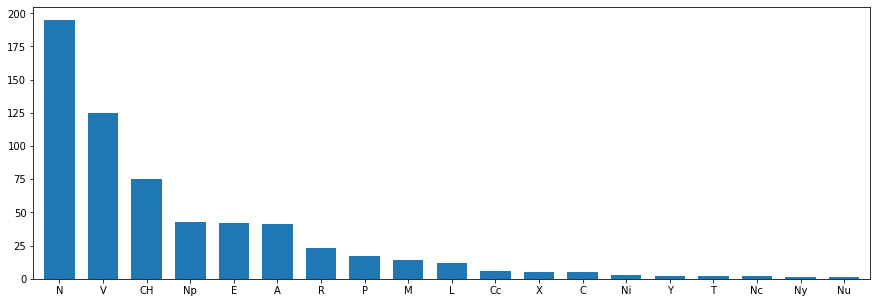

In [ ]:
print('Các từ không nằm trong vocabs', end=': ')
for word_tag, word in zip(train_gold, train_words):
    if word == '--unk--': print(word_tag.split()[0], end=', ')
plot_tag_counts(train_gold)

  - **Test Data**

In [ ]:
test_gold = open('/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/test_gold.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập test_gold:', len(test_gold))
test_gold[0:5]

Số lượng từ trong tập test_gold: 132


['SUV\tY\n', 'chạy\tV\n', 'xăng\tN\n', ',\tCH\n', 'sạc\tV\n']

In [ ]:
test_words = preprocess(vocabs_dict, '/content/gdrive/MyDrive/Colab/Xử lý ngôn ngữ tự nhiên/dataset/test_words.txt')
print('Số lượng từ trong tập test_words:', len(test_words))
test_words[0:5]

Số lượng từ trong tập test_words: 132


['--unk--', 'chạy', 'xăng', ',', 'sạc']

Các từ không nằm trong vocabs: SUV, Bỉ, CĐV, VAR, Bắc_Kinh, Nga, Belarus, Nga, 

,N,V,CH,E,Np,A,R,P,Ni,L,C,Y,Total
0,38,29,15,9,8,5,4,4,3,2,2,1,120


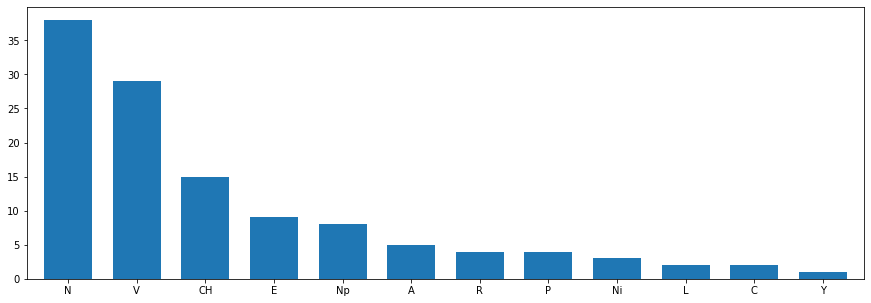

In [ ]:
print('Các từ không nằm trong vocabs', end=': ')
for word_tag, word in zip(test_gold, test_words):
    if word == '--unk--': print(word_tag.split()[0], end=', ')
plot_tag_counts(test_gold)

# **5. Hidden Markov Model**


## **Tạo từ điển**

In [ ]:
def seperate_word_tag(word_tag, vocabs_dict): 
    if not word_tag.split():
        word = '--n--'
        tag = '--s--'
    else:
        word, tag = word_tag.split()
        if word not in vocabs_dict: word = '--unk--'
    return word, tag

In [ ]:
def create_dictionaries(train_gold, vocab):
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    prev_tag = '--s--' 
    for word_tag in train_gold:
        word, tag = seperate_word_tag(word_tag, vocab) 
        
        transition_counts[(prev_tag, tag)] += 1
        emission_counts[(tag, word)] += 1
        tag_counts[tag] += 1
        prev_tag = tag
    return transition_counts, emission_counts, tag_counts

In [ ]:
transition_counts, emission_counts, tag_counts = create_dictionaries(train_gold, vocabs_dict)
states = sorted(tag_counts.keys())
print('Số nhãn:', len(states))
print(states)

Số nhãn: 20
['--s--', 'A', 'C', 'CH', 'Cc', 'E', 'L', 'M', 'N', 'Nc', 'Ni', 'Np', 'Nu', 'Ny', 'P', 'R', 'T', 'V', 'X', 'Y']


In [ ]:
print("Transition counts examples: ")
for example in list(transition_counts.items())[:5]:
    print(example)

Transition counts examples: 
(('--s--', 'E'), 4)
(('E', 'A'), 3)
(('A', 'M'), 4)
(('M', 'N'), 8)
(('N', 'X'), 2)


In [ ]:
print("Emission counts examples: ")
for example in list(emission_counts.items())[:5]:
    print (example)

Emission counts examples: 
(('E', 'Trong'), 2)
(('A', 'hơn'), 3)
(('M', '1.500'), 1)
(('N', '--unk--'), 13)
(('X', 'ngoài_trời'), 1)


In [ ]:
print("Tag counts examples: ")
for example in list(tag_counts.items())[:5]:
    print (example)

Tag counts examples: 
('E', 42)
('A', 41)
('M', 14)
('N', 195)
('X', 5)


## **Parts of Speech Tagging**

In [ ]:
# TEST
def predict_pos(words, gold, emission_counts, vocabs_dict, states):
    num_correct = 0
    all_words = set(emission_counts.keys())
    
    for word, gold_tuple in zip(words, gold): 
        gold_tuple_list = gold_tuple.split()
        if len(gold_tuple_list) != 2: continue
        else: true_label = gold_tuple_list[1]
    
        count_final = 0
        pos_final = ''
        if word not in vocabs_dict: continue
        
        for pos in states:
            if (pos, word) not in emission_counts: continue
            count = emission_counts[(pos, word)]
            
            if count > count_final:
                count_final = count
                pos_final = pos
                    
        if pos_final == true_label: num_correct += 1
    accuracy = num_correct / len(gold)
    return accuracy

In [ ]:
# TEST
accuracy = predict_pos(train_words, train_gold, emission_counts, vocabs_dict, states)
print('Độ chính xác trên tập train:', accuracy)

Độ chính xác trên tập train: 0.8986384266263238


In [ ]:
# TEST
accuracy = predict_pos(test_words, test_gold, emission_counts, vocabs_dict, states)
print('Độ chính xác trên tập test:', accuracy)

Độ chính xác trên tập test: 0.3712121212121212


##**Ma trận chuyển tiếp A**

In [ ]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    all_tags = sorted(tag_counts.keys())
    num_tags = len(all_tags)
    
    A = np.zeros((num_tags, num_tags))
    trans_keys = set(transition_counts.keys())
    
    for i in range(num_tags):
        for j in range(num_tags):
            count = 0
            key = (all_tags[i], all_tags[j])
            if key in transition_counts: count = transition_counts[key]
                
            count_prev_tag = tag_counts[all_tags[i]]
            A[i, j] = (count + alpha) / (count_prev_tag + alpha * num_tags)
    return A

In [ ]:
alpha = 0.001
for i in range(len(states)): tag_counts.pop(i, None)
    
A = create_transition_matrix(alpha, tag_counts, transition_counts)
df = pd.DataFrame(
    A[:5, :10], 
    index = states[:5], 
    columns = states[:10]
)
df.head()

,--s--,A,C,CH,Cc,E,L,M,N,Nc
--s--,0.000021,0.106359,0.000021,0.000021,0.000021,0.085091,0.085091,0.000021,0.446640,0.021289
A,0.000024,0.097538,0.048781,0.219430,0.000024,0.121916,0.048781,0.097538,0.170673,0.000024
C,0.000199,0.199402,0.000199,0.000199,0.000199,0.000199,0.000199,0.000199,0.000199,0.000199
CH,0.626513,0.013343,0.000013,0.013343,0.000013,0.000013,0.000013,0.000013,0.266609,0.000013
Cc,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.996844,0.000166


##**Ma trận phát xạ B**

In [ ]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocabs):
    all_tags = sorted(tag_counts.keys())
    num_tags = len(tag_counts)
    num_words = len(vocabs)
    
    B = np.zeros((num_tags, num_words))
    emis_keys = set(list(emission_counts.keys()))
    
    for i in range(num_tags):
        for j in range(num_words):
            count = 0
            key = (all_tags[i], vocabs[j])
            if key in emission_counts.keys(): count = emission_counts[key]
                
            count_tag = tag_counts[all_tags[i]]
            B[i, j] = (count + alpha) / (count_tag + alpha * num_words)
    return B

In [ ]:
cidx  = ['Công_nghệ_thông_tin', 'là', 'lĩnh_vực', 'có', 'tiềm_năng', 'phát_triển']
rvals = ['P', 'N', 'V', 'CH', 'Cc', 'E', 'L',]
cols = [vocabs_dict[word] for word in cidx]
rows = [states.index(tag) for tag in rvals]

for i in range(len(states)): tag_counts.pop(i, None)
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocabs_dict))

df = pd.DataFrame(B[np.ix_(rows, cols)], index=rvals, columns=cidx)
df.head()

,Công_nghệ_thông_tin,là,lĩnh_vực,có,tiềm_năng,phát_triển
P,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014
N,0.004006,0.000004,0.012011,0.000004,0.004006,0.000004
V,0.000006,0.055606,0.000006,0.027806,0.000006,0.011126
CH,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
Cc,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016


# **6. Thuật toán Viterbi**

In [ ]:
A = np.array([sublist[1:].tolist() for sublist in A])
B = B[1:]

## Initialize

In [ ]:
def viterbi_initialize(states, tag_counts, A, B, corpus, vocabs_dict):
    num_tags = len(tag_counts)
    s_idx = states.index('--s--')
    
    best_probs = np.zeros((num_tags, len(corpus)))
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    for i in range(num_tags):
        if A[s_idx, i - 1] == 0: best_probs[i, 0] = float('-inf')
        else: 
            index = vocabs_dict[corpus[0]]
            # best_probs[i, 0] = math.log(A[s_idx, i]) + math.log(B[i, index])
            best_probs[i, 0] = math.log(A[s_idx, i - 1]) + math.log(B[i - 1, index])
    return best_probs, best_paths

In [ ]:
best_probs_train, best_paths_train = viterbi_initialize(states, tag_counts, A, B, train_words, vocabs_dict)
print('best_probs_train[0, 0]:', best_probs_train[0, 0])
print(best_probs_train.shape)
print('best_paths_train[2, 3]:', best_paths_train[2, 3])
print(best_paths_train.shape)
print('best_probs_train')
print(best_probs_train)
print('best_paths_train')
print(best_paths_train)

best_probs_train[0, 0]: -21.70657017939562
(20, 661)
best_paths_train[2, 3]: 0
(20, 661)
best_probs_train
[[-21.70657018   0.           0.         ...   0.           0.
    0.        ]
 [-13.71151663   0.           0.         ...   0.           0.
    0.        ]
 [-21.75799186   0.           0.         ...   0.           0.
    0.        ]
 ...
 [-15.94947423   0.           0.         ...   0.           0.
    0.        ]
 [-14.84923709   0.           0.         ...   0.           0.
    0.        ]
 [-21.70657018   0.           0.         ...   0.           0.
    0.        ]]
best_paths_train
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
best_probs_test, best_paths_test = viterbi_initialize(states, tag_counts, A, B, test_words, vocabs_dict)
print('best_probs_test[0, 0]:', best_probs_test[0, 0]) 
print('best_paths_test[2, 3]:', best_paths_test[2, 3])
print(best_probs_test.shape)
print('best_probs_test')
print(best_probs_test)
print('best_paths_test')
print(best_paths_test)

best_probs_test[0, 0]: -14.105167844811884
best_paths_test[2, 3]: 0
(20, 132)
best_probs_test
[[-14.10516784   0.           0.         ...   0.           0.
    0.        ]
 [ -6.80276185   0.           0.         ...   0.           0.
    0.        ]
 [-21.75799186   0.           0.         ...   0.           0.
    0.        ]
 ...
 [ -9.04071945   0.           0.         ...   0.           0.
    0.        ]
 [ -7.94048231   0.           0.         ...   0.           0.
    0.        ]
 [-14.10516784   0.           0.         ...   0.           0.
    0.        ]]
best_paths_test
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##**Forward**

In [ ]:
def viterbi_forward(A, B, corpus, best_probs, best_paths, vocabs_dict):
    num_tags = best_probs.shape[0]
    
    for i in range(1, len(corpus)): 
        if i % 5000 == 0: print(f'Processed {i} words...')
            
        for j in range(num_tags):
            best_prob_i = float('-inf')
            best_path_i = None
            
            for k in range(num_tags):
                index = vocabs_dict[corpus[i]]
                # prob = best_probs[k, i - 1] + math.log(A[k, j]) + math.log(B[j, index])
                prob = best_probs[k, i - 1] + math.log(A[k, j - 1]) + math.log(B[j - 1, index])

                if prob > best_prob_i:
                    best_prob_i = prob
                    best_path_i = k
                    
            best_probs[j, i] = best_prob_i
            best_paths[j, i] = best_path_i
            
    return best_probs, best_paths

In [ ]:
best_probs_train, best_paths_train = viterbi_forward(A, B, train_words, best_probs_train, best_paths_train, vocabs_dict)
print('best_probs_train[0, 1]:', best_probs_train[0, 5]) 
print('best_paths_train[0, 4]:', best_paths_train[0, 4])

print('best_probs_train')
print(best_probs_train)
print('best_paths_train')
print(best_paths_train)


best_probs_train[0, 1]: -50.66173106625405
best_paths_train[0, 4]: 8
best_probs_train
[[  -21.70657018   -21.0289744    -27.10796922 ... -4170.03402047
  -4180.07943618 -4188.35432313]
 [  -13.71151663   -12.44666711   -26.24476401 ... -4169.17081527
  -4173.69302102 -4185.91498241]
 [  -21.75799186   -27.73159287   -26.46674335 ... -4169.3927946
  -4180.13085786 -4187.71309726]
 ...
 [  -15.94947423   -22.18063323   -26.46870143 ... -4169.39475268
  -4173.22439417 -4185.15806976]
 [  -14.84923709   -27.98915086   -34.06814568 ... -4176.99419694
  -4180.13085786 -4187.2354074 ]
 [  -21.70657018   -21.0289744    -27.10796922 ... -4170.03402047
  -4180.07943618 -4188.35432313]]
best_paths_train
[[0 5 1 ... 1 3 1]
 [0 5 1 ... 1 3 8]
 [0 1 1 ... 1 3 1]
 ...
 [0 5 1 ... 1 3 8]
 [0 5 1 ... 1 3 8]
 [0 5 1 ... 1 3 1]]


In [ ]:
best_probs_test, best_paths_test = viterbi_forward(A, B, test_words, best_probs_test, best_paths_test, vocabs_dict)
print('best_probs_test[0, 1]:', best_probs_test[0, 1]) 
print('best_paths_test[0, 4]:', best_paths_test[0, 4])

print('best_probs_test')
print(best_probs_test)
print('best_paths_test')
print(best_paths_test)


best_probs_test[0, 1]: -21.464063960448403
best_paths_test[0, 4]: 3
best_probs_test
[[  -14.10516784   -21.46406396   -32.03717161 ... -1296.32500912
  -1301.80208784 -1315.10774354]
 [   -6.80276185   -18.02054707   -29.79430603 ... -1287.99354046
  -1300.44644143 -1314.19672035]
 [  -21.75799186   -17.9684332    -32.04062331 ... -1289.46767602
  -1302.0136167  -1314.46651767]
 ...
 [   -9.04071945   -16.36155298   -29.80465196 ... -1287.39081717
  -1300.45678736 -1313.41995974]
 [   -7.94048231   -17.9684332    -32.18869075 ... -1289.46767602
  -1302.41788791 -1315.02683996]
 [  -14.10516784   -21.46406396   -32.03717161 ... -1296.32500912
  -1301.80208784 -1315.10774354]]
best_paths_test
[[ 0  1  5 ... 17  5  1]
 [ 0  8 15 ... 17 15 15]
 [ 0 11  1 ... 17  1  1]
 ...
 [ 0 11 15 ... 17 15 11]
 [ 0 11 17 ... 17 11 11]
 [ 0  1  5 ... 17  5  1]]


##**Backward**

In [ ]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    m = best_paths.shape[1] 
    z = [None] * m
    pred = [None] * m
    
    best_prob_for_last_word = float('-inf')
    num_tags = best_probs.shape[0]
    
    for k in range(num_tags):
        if best_probs[k, m - 1] > best_prob_for_last_word:
            best_prob_for_last_word = best_probs[k, m - 1]
            z[m - 1] = k
            
    pred[m - 1] = states[z[m - 1]]
    for i in range(m - 1, -1, -1):
        z[i - 1] = best_paths[z[i], i]
        pred[i - 1] = states[z[i - 1]]
    return pred

In [ ]:
train_pred = viterbi_backward(best_probs_train, best_paths_train, train_words, states)
test_pred = viterbi_backward(best_probs_test, best_paths_test, test_words, states)
m = len(test_pred)



print('Dự đoán cho tập test:')
print(test_words[22:30])
print(test_pred[22:30])
print()
print(test_words[22:30])
print(test_pred[22:30])

Dự đoán cho tập test:
['Nhưng', 'sự', 'thực_hiện', 'vẫn', 'còn', 'chưa', 'phù_hợp', '.']
['V', 'N', 'V', 'R', 'V', 'R', 'A', 'CH']

['Nhưng', 'sự', 'thực_hiện', 'vẫn', 'còn', 'chưa', 'phù_hợp', '.']
['V', 'N', 'V', 'R', 'V', 'R', 'A', 'CH']


In [ ]:
for word, tag in zip(test_words, test_pred):
    if word == '--n--': print()
    else: print(f'{word}/{tag}', end=' ')

--unk--/Np chạy/R xăng/A ,/CH sạc/N điện/V hiện/N có/V lượng/V bình_chọn/R cao/A nhất/A phân/C khúc/R so/V với/E các/L đối_thủ/N thuần/R động_cơ_đốt_trong/A ./CH 
Nhưng/V sự/N thực_hiện/V vẫn/R còn/V chưa/R phù_hợp/A ./CH 
Những/L ngày/N đẹp_đẽ/T ấy/P ,/CH bố/N luôn/T dành/P thời_gian/V để/E vui_vẻ/Np với/E anh_em/N tôi/P ./CH 
Cổ_động_viên/Np đốt_phá/V trong/E bạo_loạn/Np ở/E --unk--/Np ./CH 
--unk--/Np tự/R làm/V --unk--/Np bằng/V ống_nhòm/E gây/L sốt/N ./CH 
--unk--/Np cấm/V nhân_viên/R chống/V dịch/N chặn/V cổng/N nhà/N dân/N ./CH 
Ukraine/V nghi/E --unk--/Np sắp/V điều/E thêm/Np quân/V từ/E --unk--/Np ./CH 
Lưới_điện/V Ukraine/R bên/A bờ/C vực/R sụp_đổ/V trước/E đòn/L tên_lửa/N --unk--/Np ./CH 
Châu_Âu/R chạy_đua/A bảo_vệ/C huyết_mạch/R năng_lượng/V dưới/E đáy/N biển/Np ./CH 
Con_mèo/V trèo/E cây/L cau/N ./CH 
Con_chuột/V trèo/E cây/L cau/N ./CH 
Con_chuột/V hỏi/E con_mèo/Np ./CH 
Con/T trèo/P là/V con/E nào/Np ./--s-- 

# **7. Đánh giá**

In [ ]:
from sklearn.metrics import classification_report
def report(pred, gold):
    y_pred = []
    y_true = []

    for prediction, word_tag in zip(pred, gold):
        word_tag_tuple = word_tag.split()
        if len(word_tag_tuple) != 2: continue 

        word, tag = word_tag_tuple
        y_pred.append(prediction)
        y_true.append(tag)
        
    print(classification_report(y_pred, y_true))
    return y_pred, y_true

## **HMM**

In [ ]:
print('Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập train:\n')
y_pred, y_true_train = report(train_pred, train_gold)

Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập train:

              precision    recall  f1-score   support

       --s--       0.00      0.00      0.00         1
           A       0.98      1.00      0.99        40
           C       1.00      1.00      1.00         5
          CH       1.00      1.00      1.00        75
          Cc       1.00      1.00      1.00         6
           E       1.00      1.00      1.00        42
           L       1.00      1.00      1.00        12
           M       0.93      1.00      0.96        13
           N       0.99      0.96      0.97       202
          Nc       1.00      1.00      1.00         2
          Ni       1.00      1.00      1.00         3
          Np       0.88      0.90      0.89        42
          Nu       0.00      0.00      0.00         0
          Ny       0.00      0.00      0.00         0
           P       1.00      1.00      1.00        17
           R       1.00      1.00      1.00        23
   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
print('Kết quả của mô hình Hidden Markov và thuật toán Viterbi trên tập test:\n')
y_pred, y_true_test = report(test_pred, test_gold)

Kết quả của mô hình Hidden Markov và thuật toán Viterbi trên tập test:

              precision    recall  f1-score   support

       --s--       0.00      0.00      0.00         1
           A       0.40      0.29      0.33         7
           C       0.00      0.00      0.00         3
          CH       0.93      1.00      0.97        14
           E       0.89      0.53      0.67        15
           L       1.00      0.33      0.50         6
           N       0.34      0.81      0.48        16
          Ni       0.00      0.00      0.00         0
          Np       0.62      0.33      0.43        15
           P       0.50      0.50      0.50         4
           R       0.50      0.17      0.25        12
           T       0.00      0.00      0.00         3
           V       0.34      0.42      0.38        24
           Y       0.00      0.00      0.00         0

    accuracy                           0.48       120
   macro avg       0.40      0.31      0.32       120
weighted

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

## **VNCORE**

In [ ]:
y_pred = []
for word_tag in test_gold:
    word_tag_tuple = word_tag.split()
    if len(word_tag_tuple) != 2: 
        print()
        continue

    word, tag = word_tag_tuple
    if '_' not in word: pred = model.annotate_text(word)
    else: pred = model.annotate_text(word.replace('_', ' '))

    print(word+"/"+pred[0][0]['posTag'], end=' ') 
    y_pred.append(pred[0][0]['posTag'])

SUV/Np chạy/V xăng/N ,/CH sạc/V điện/N hiện/N có/V lượng/N bình_chọn/V cao/A nhất/A phân/V khúc/N so/V với/E các/L đối_thủ/N thuần/A động_cơ_đốt_trong/V ./CH 
Nhưng/C sự/N thực_hiện/V vẫn/R còn/C chưa/R phù_hợp/V ./CH 
Những/L ngày/N đẹp_đẽ/A ấy/P ,/CH bố/N luôn/R dành/V thời_gian/N để/E vui_vẻ/A với/E anh_em/N tôi/P ./CH 
Cổ_động_viên/Np đốt_phá/V trong/E bạo_loạn/V ở/E Bỉ/Np ./CH 
CĐV/Np tự/P làm/V VAR/Np bằng/E ống_nhòm/N gây/V sốt/V ./CH 
Bắc_Kinh/Np cấm/V nhân_viên/N chống/V dịch/V chặn/V cổng/N nhà/N dân/N ./CH 
Ukraine/Np nghi/V Nga/Np sắp/R điều/N thêm/V quân/N từ/E Belarus/Np ./CH 
Lưới_điện/Np Ukraine/Np bên/N bờ/N vực/V sụp_đổ/V trước/E đòn/N tên_lửa/N Nga/Np ./CH 
Châu_Âu/Np chạy_đua/V bảo_vệ/V huyết_mạch/N năng_lượng/N dưới/E đáy/N biển/N ./CH 
Con_mèo/Nc trèo/V cây/N cau/N ./CH 
Con_chuột/Nc trèo/V cây/N cau/N ./CH 
Con_chuột/Nc hỏi/V con_mèo/Nc ./CH 
Con/Np trèo/V là/V con/N nào/P ./CH 

In [ ]:
print('Kết quả khi sử dụng thư viện VnCoreNLP trên tập test:\n')
print(classification_report(y_pred, y_true_test))

Kết quả khi sử dụng thư viện VnCoreNLP trên tập test:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         5
           C       1.00      1.00      1.00         2
          CH       1.00      1.00      1.00        15
           E       1.00      1.00      1.00         9
           L       1.00      1.00      1.00         2
           N       0.82      1.00      0.90        31
          Nc       0.00      0.00      0.00         4
          Ni       0.00      0.00      0.00         0
          Np       1.00      0.57      0.73        14
           P       1.00      1.00      1.00         4
           R       1.00      1.00      1.00         4
           V       1.00      0.97      0.98        30
           Y       0.00      0.00      0.00         0

    accuracy                           0.91       120
   macro avg       0.76      0.73      0.74       120
weighted avg       0.92      0.91      0.90       120



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1